In [1]:
import os
import gzip
import struct
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering as HC
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
%matplotlib inline

# 1. MNIST

## 1.1 Load data

In [2]:
def read_gzfile(file_path):
    with gzip.open(file_path, 'rb') as f:
        return f.read()

In [3]:
def decode_idx3_ubyte(idx3_ubyte_file):
    if(idx3_ubyte_file.endswith(".gz")):
        bin_data = read_gzfile(idx3_ubyte_file)
    else:
        bin_data = open(idx3_ubyte_file,'rb').read()
    offest=0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offest)
    image_size = num_rows*num_cols
    offest += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offest)).reshape((num_rows, num_cols))
        offest += struct.calcsize(fmt_image)
    return images

def decode_idx1_ubyte(idx1_ubyte_file):
    if(idx1_ubyte_file.endswith(".gz")):
        bin_data = read_gzfile(idx1_ubyte_file)
    else:
        bin_data = open(idx1_ubyte_file,'rb').read()
    offest = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offest)
    offest += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offest)[0]
        offest += struct.calcsize(fmt_image)
    return labels

In [4]:
def load_data(file_path):
    if("-idx3-ubyte" in file_path):
        return decode_idx3_ubyte(file_path)
    elif("-idx1-ubyte" in file_path):
        return decode_idx1_ubyte(file_path)

In [5]:
train_images = load_data("./data2forEx/train-images-idx3-ubyte.gz")
train_images = train_images.reshape(-1, train_images.shape[1]*train_images.shape[2])
train_labels = load_data("./data2forEx/train-labels-idx1-ubyte.gz")

test_images = load_data("./data2forEx/t10k-images-idx3-ubyte.gz")
test_images = test_images.reshape(-1, test_images.shape[1]*test_images.shape[2])
test_labels = load_data("./data2forEx/t10k-labels-idx1-ubyte.gz")

## 1.2 Category = 6

In [6]:
category = 6
print(category)

6


In [7]:
cate_images = train_images[np.where(train_labels==category)[0]]
cate_labels = train_labels[np.where(train_labels==category)[0]]

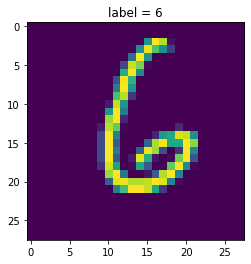

In [8]:
plt.figure()
plt.imshow(cate_images[2].reshape((28,28)))
plt.title("label = %d"%(cate_labels[2]))
plt.show()

### 1.2.1 PCA降维

In [9]:
pca = PCA()
pca.fit(cate_images)

PCA()

In [10]:
def calculateNPCs(explained_variance_ratio_, ratio=0):
    n_PCs = 0
    summary = 0
    for i, eigen_value in enumerate(explained_variance_ratio_):
        summary += eigen_value
        if(summary >= ratio):
            n_PCs = i
            break
    return n_PCs

In [11]:
n_PCs = calculateNPCs(pca.explained_variance_ratio_, ratio=0.95)
print("选择占比超过95%%的n_Pc = %d"%(n_PCs))

选择占比超过95%的n_Pc = 112


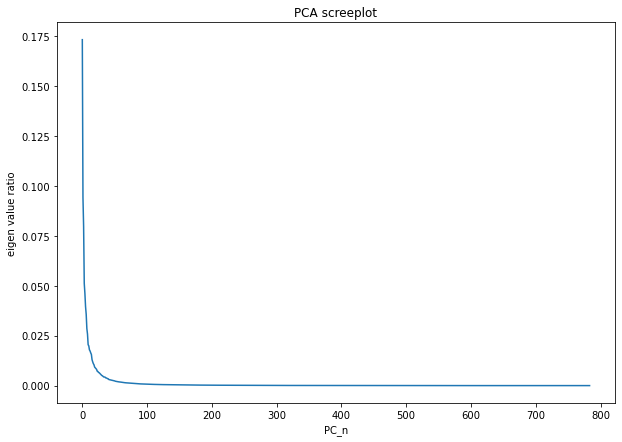

In [12]:
plt.figure(figsize=(10,7))
plt.plot(pca.explained_variance_ratio_, "-")
plt.xlabel("PC_n")
plt.ylabel("eigen value ratio")
plt.title("PCA screeplot")
plt.show()

In [13]:
pca = PCA(n_components = n_PCs)
cate_images_transformed = pca.fit_transform(cate_images)

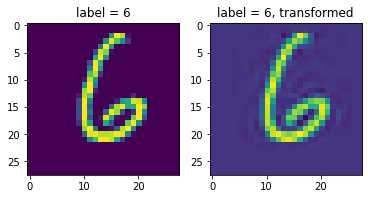

In [14]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cate_images[2].reshape((28,28)))
plt.title("label = %d"%(cate_labels[2]))
plt.subplot(1,2,2)
plt.imshow(pca.inverse_transform(cate_images_transformed[2]).reshape((28,28)))
plt.title("label = %d, transformed"%(cate_labels[2]))
plt.show()

### 1.2.2 Clustering

In [15]:
def cluster_visualization(datas, clusters):
    labels = np.unique(clusters)
    colors = ["red", "green", "blue", "orange", "purple", "gold", "teal", "cyan", "thistle", "black"]
    tsne = TSNE(n_components=2, random_state=42)
    dots = tsne.fit_transform(datas)
    plt.figure(figsize=(10,10))
    for i, label in enumerate(labels):
        idx = np.where(clusters==label)[0]
        plt.plot(dots[idx,0], dots[idx,1], ".", color=colors[i], label=label)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.legend()
    plt.show()
    
    n_clusters = len(labels)
    n_figures = 5
    plt.figure(figsize=(5*n_figures, 5*n_clusters))
    i = 0
    for j, label in enumerate(labels):
        idxs = np.where(clusters==label)[0][:n_figures]
        for k, idx in enumerate(idxs):
            plt.subplot(n_clusters, n_figures, i+1)
            plt.imshow(pca.inverse_transform(datas[idx]).reshape((28,28)))
            plt.title("cluster %d, sample %d"%(j, k+1))
            i += 1
    plt.show()

#### 1.2.2.1 KMeans

In [16]:
def kmeans_plot(datas, labels, title = None):
    if(title is not None):
        plt.title(title)
    SSEs = []
    SCs = []
    ks = list(range(2, 20))
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(datas)
        SSEs.append(kmeans.inertia_)
        SCs.append(silhouette_score(datas, kmeans.labels_))

    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.xlabel("n_clusters")
    plt.ylabel("SSE")
    plt.plot(ks, SSEs)
    plt.subplot(1,2,2)
    plt.xlabel("n_clusters")
    plt.ylabel("silhouette_score")
    plt.plot(ks, SCs)
    plt.show()

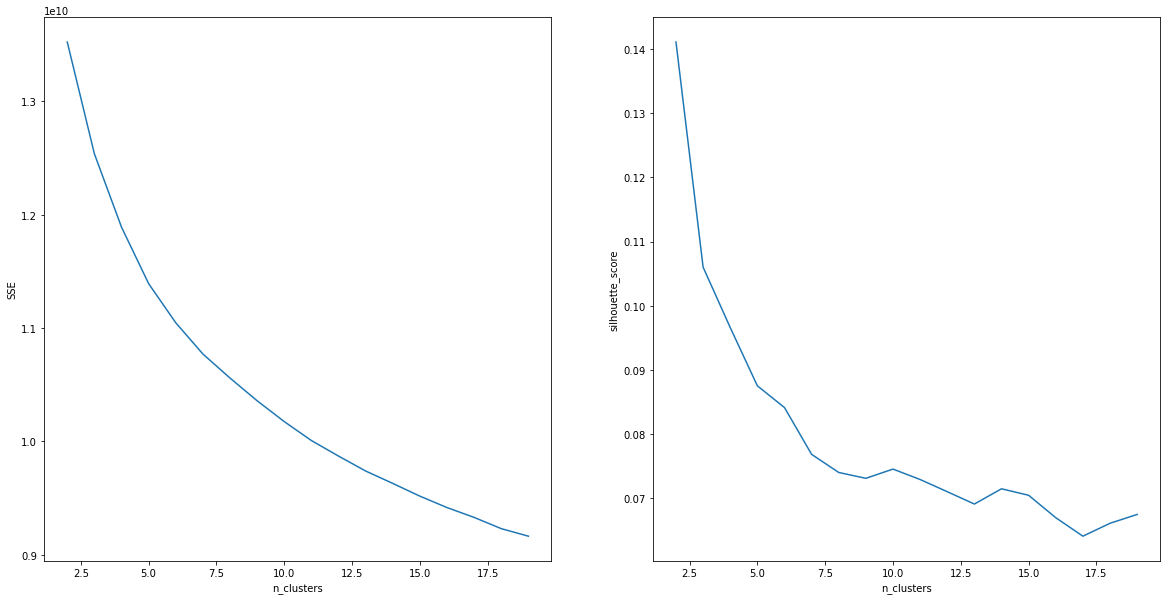

In [17]:
kmeans_plot(cate_images_transformed, cate_labels, title = None)

根据轮廓系数和SSE，选取n_clusters = 10

In [18]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(cate_images_transformed)
kmeans.labels_

array([7, 4, 9, ..., 6, 6, 6], dtype=int32)

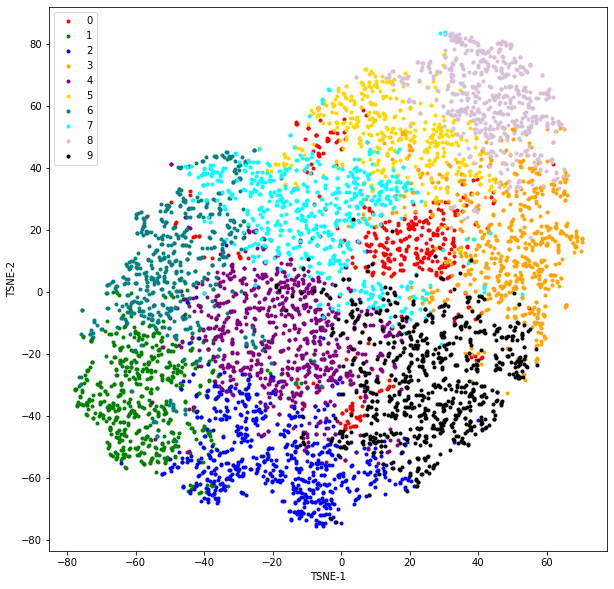

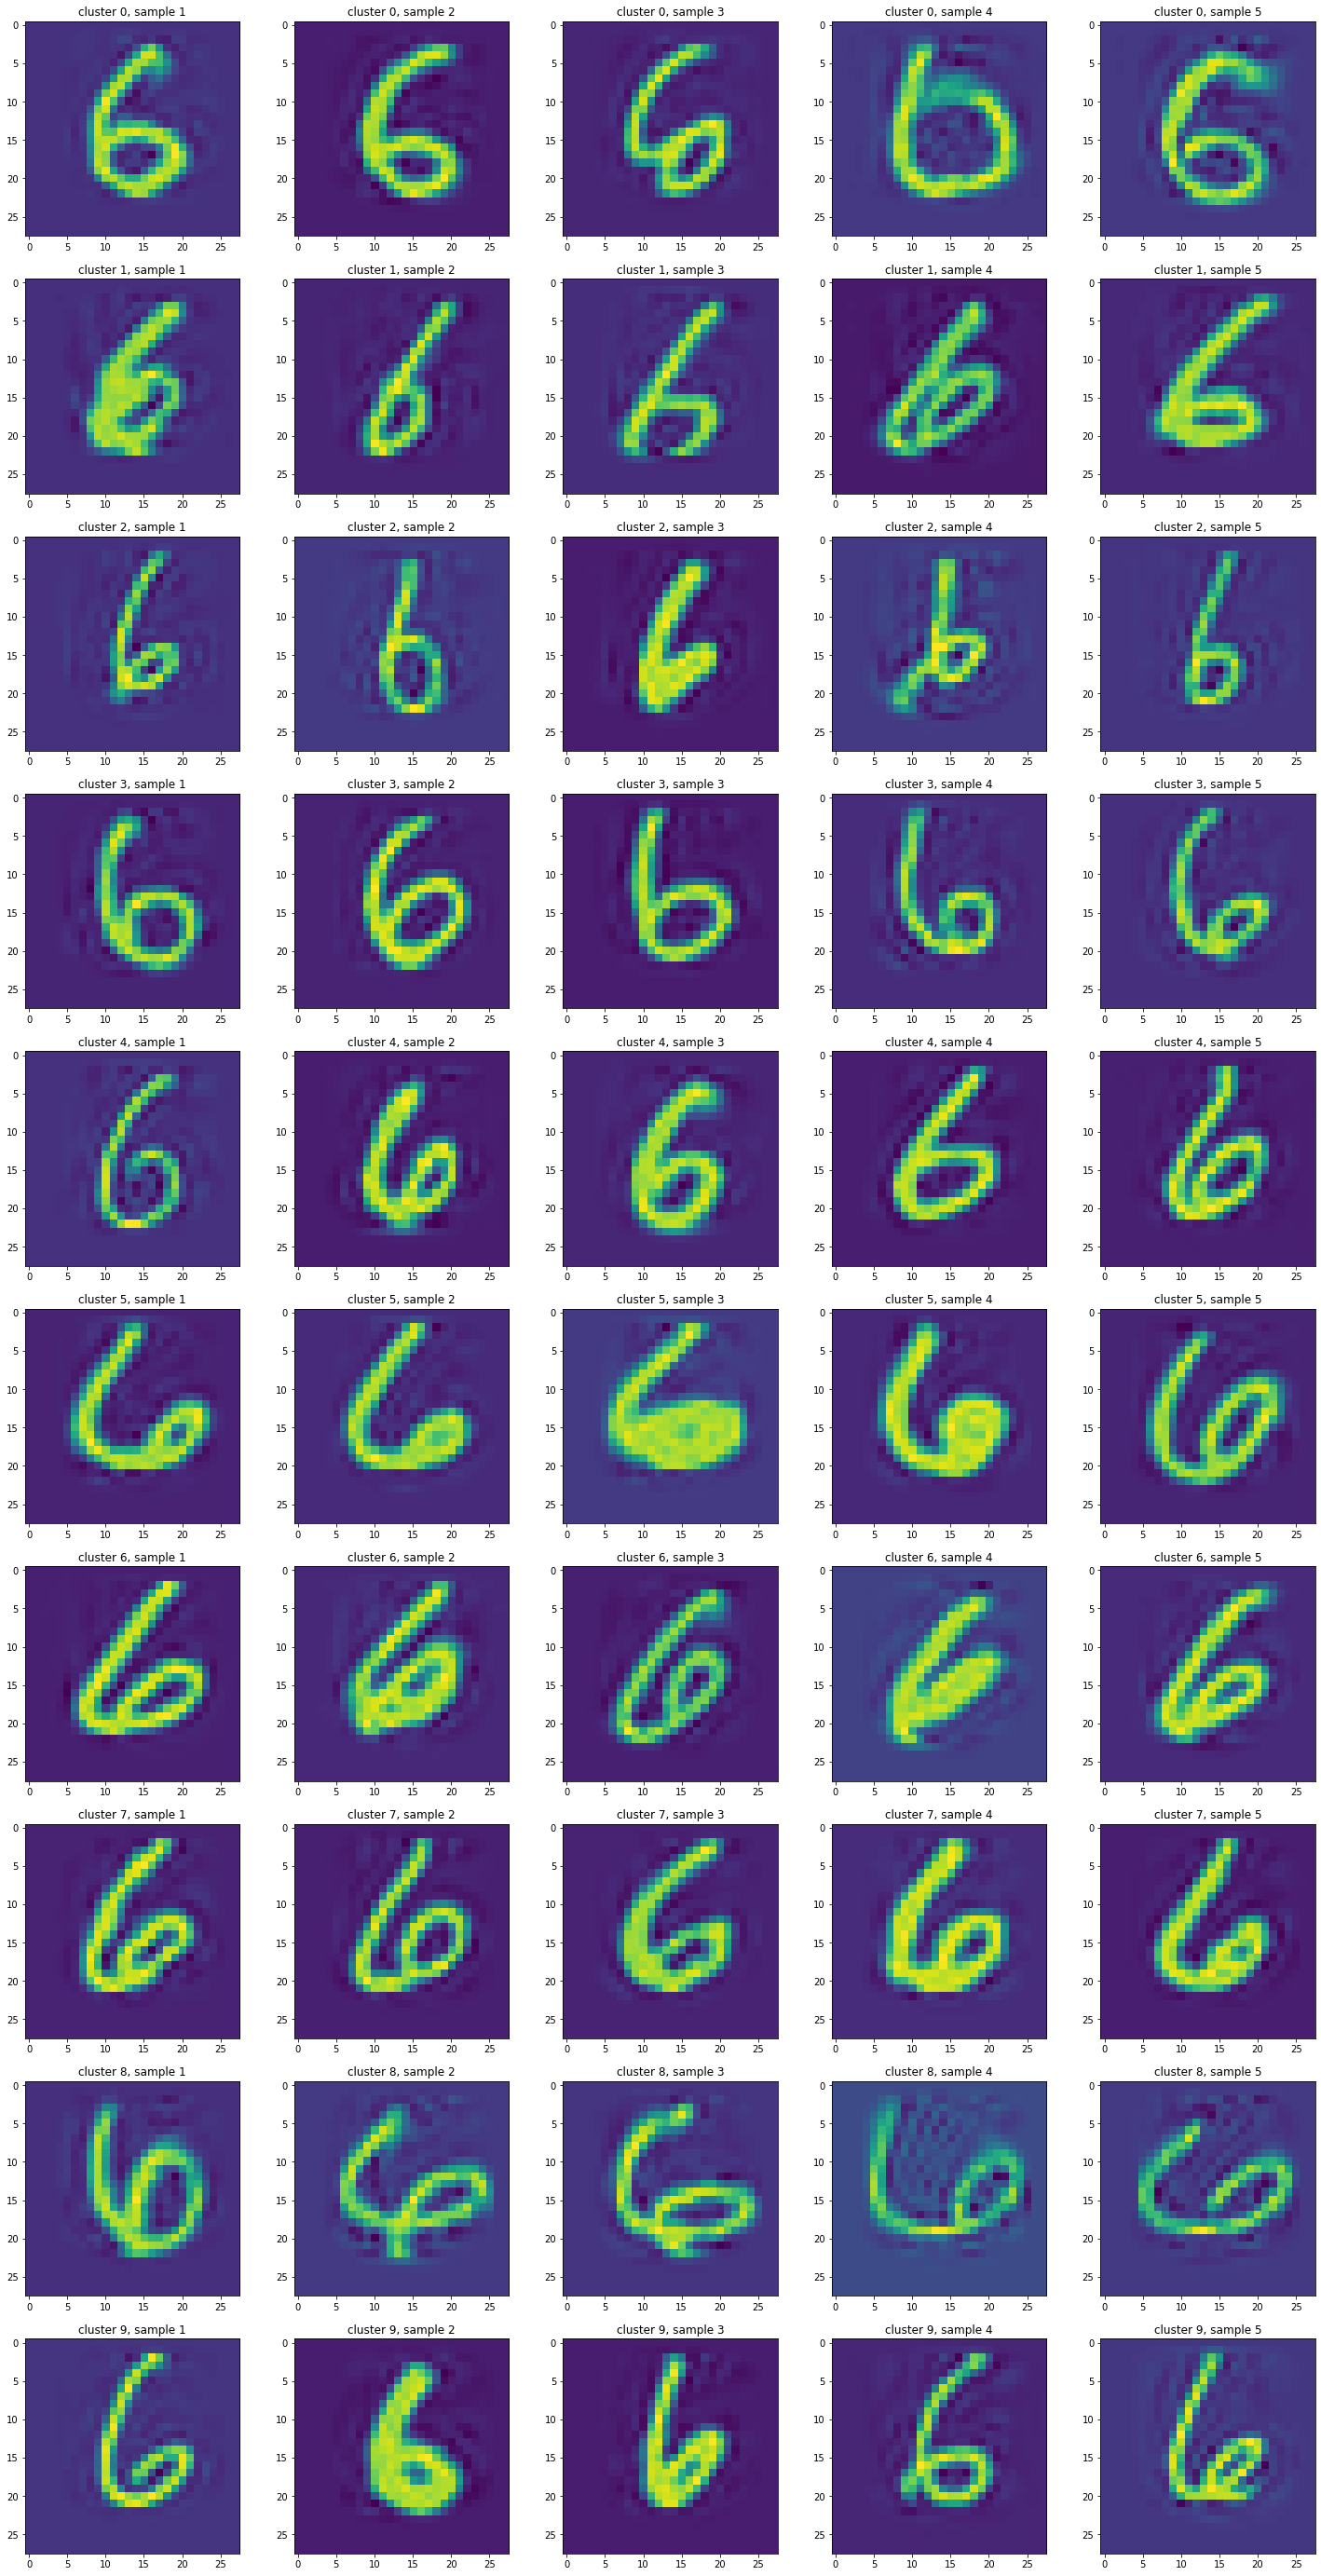

In [19]:
cluster_visualization(cate_images_transformed, kmeans.labels_)

#### 1.2.2.2 GMM

In [20]:
def gmm_plot(datas, labels, title = None):
    if(title is not None):
        plt.title(title)

    SCs = []
    ks = list(range(2, 20))
    for k in ks:
        gmm = GMM(n_components=k, random_state=42)
        clusters = gmm.fit_predict(datas)
        SCs.append(silhouette_score(datas, clusters))

    plt.figure(figsize=(10,10))
    plt.xlabel("n_clusters")
    plt.ylabel("silhouette_score")
    plt.plot(ks, SCs)
    plt.show()

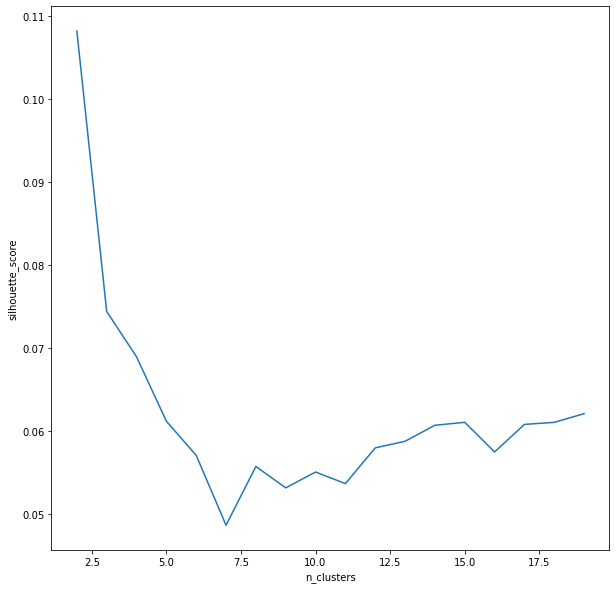

In [21]:
gmm_plot(cate_images_transformed, cate_labels)

In [22]:
gmm = GMM(n_components = 8, random_state=42)
gmm_label = gmm.fit_predict(cate_images_transformed)

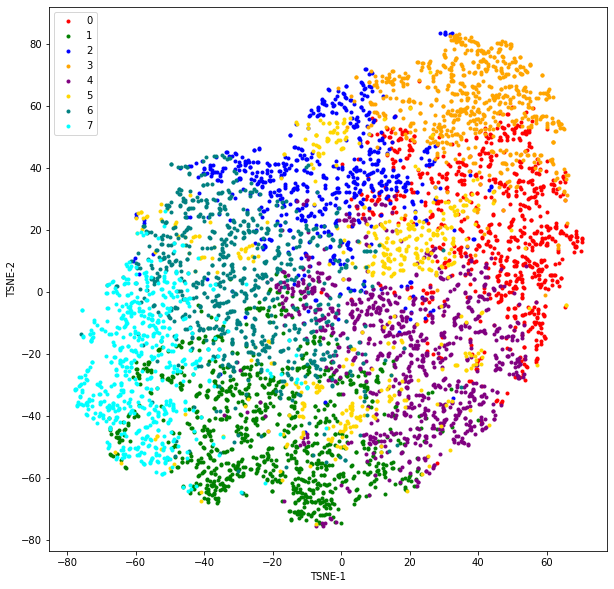

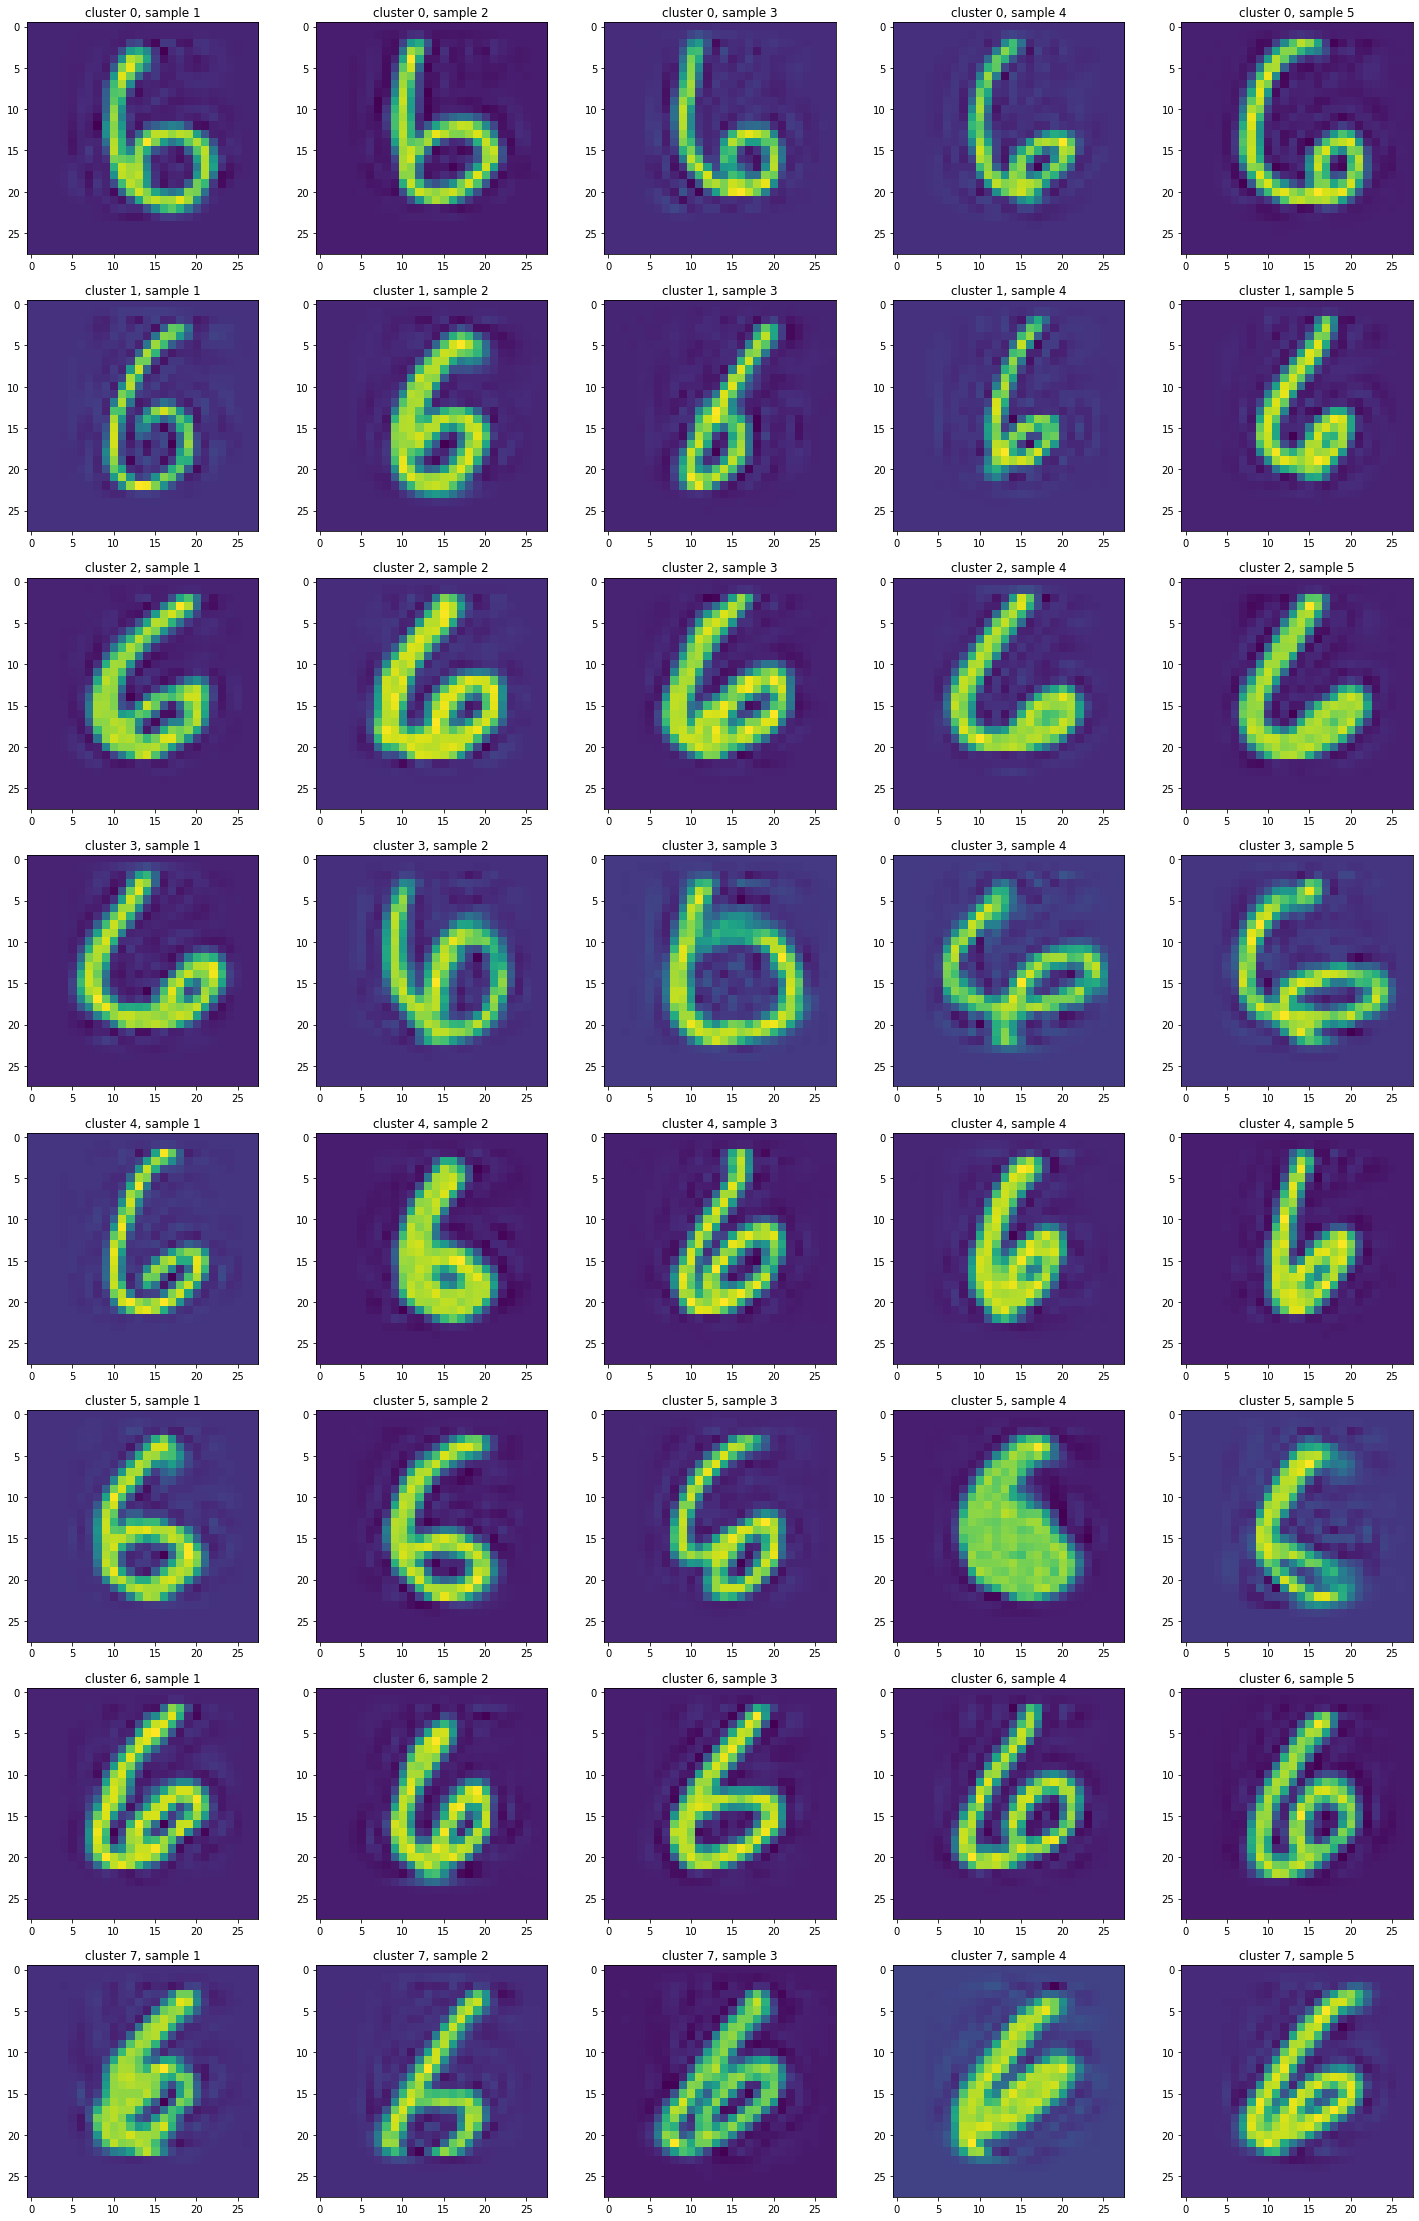

In [23]:
cluster_visualization(cate_images_transformed, gmm_label)

#### 1.2.2.3 Hierarchical clustering

In [24]:
def HC_plot(datas, labels, title = None):
    if(title is not None):
        plt.title(title)

    SCs = []
    ks = list(range(2, 20))
    for k in ks:
        hc = HC(n_clusters=k)
        clusters = hc.fit_predict(datas)
        SCs.append(silhouette_score(datas, clusters))

    plt.figure(figsize=(10,10))
    plt.xlabel("n_clusters")
    plt.ylabel("silhouette_score")
    plt.plot(ks, SCs)
    plt.show()

In [25]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

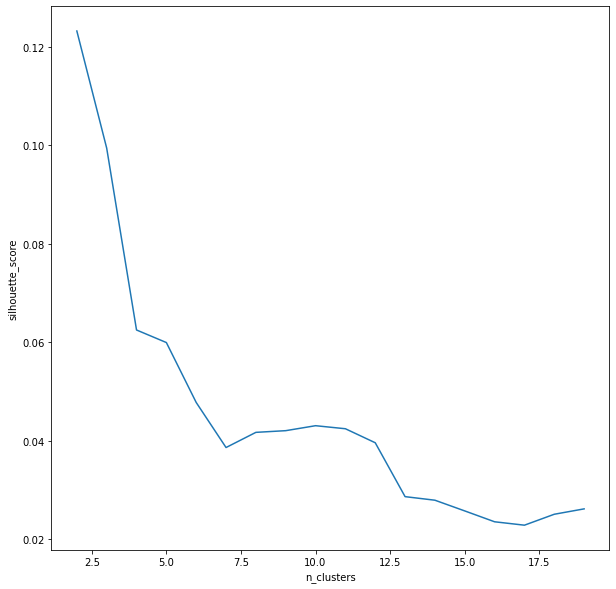

In [26]:
HC_plot(cate_images_transformed, cate_labels)

In [27]:
hc = HC(distance_threshold=0, n_clusters=None)
hc_label = hc.fit_predict(cate_images_transformed)

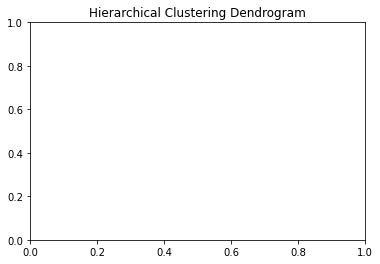

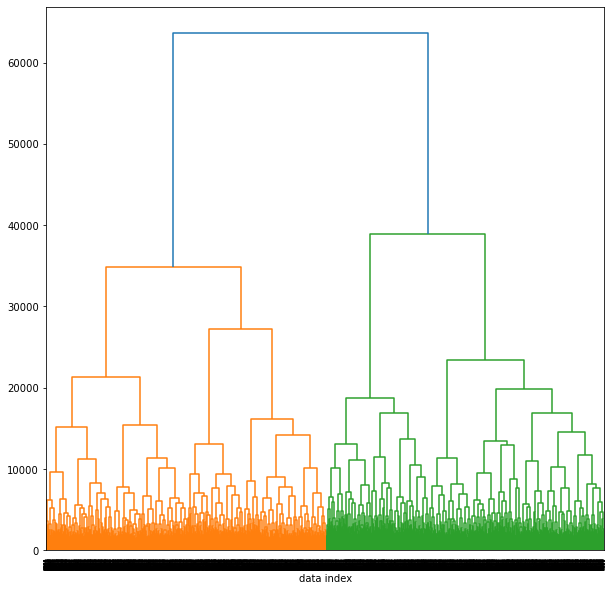

In [28]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plt.figure(figsize=(10,10))
plot_dendrogram(hc)
plt.xlabel("data index")
plt.show()

In [29]:
hc = HC(n_clusters=9)
hc_label = hc.fit_predict(cate_images_transformed)

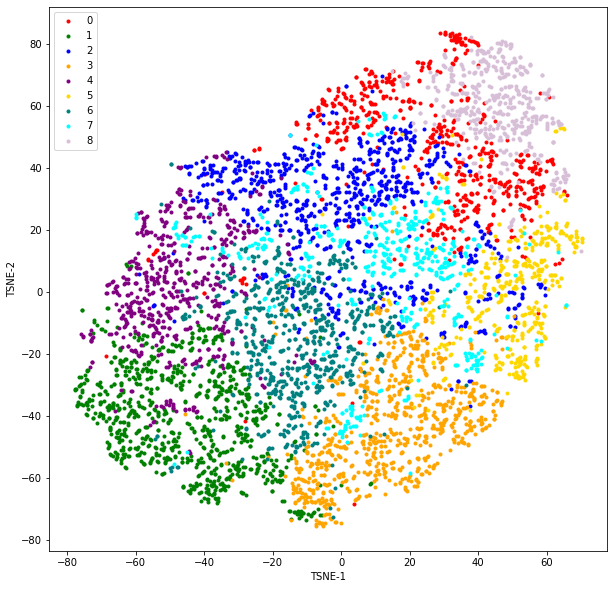

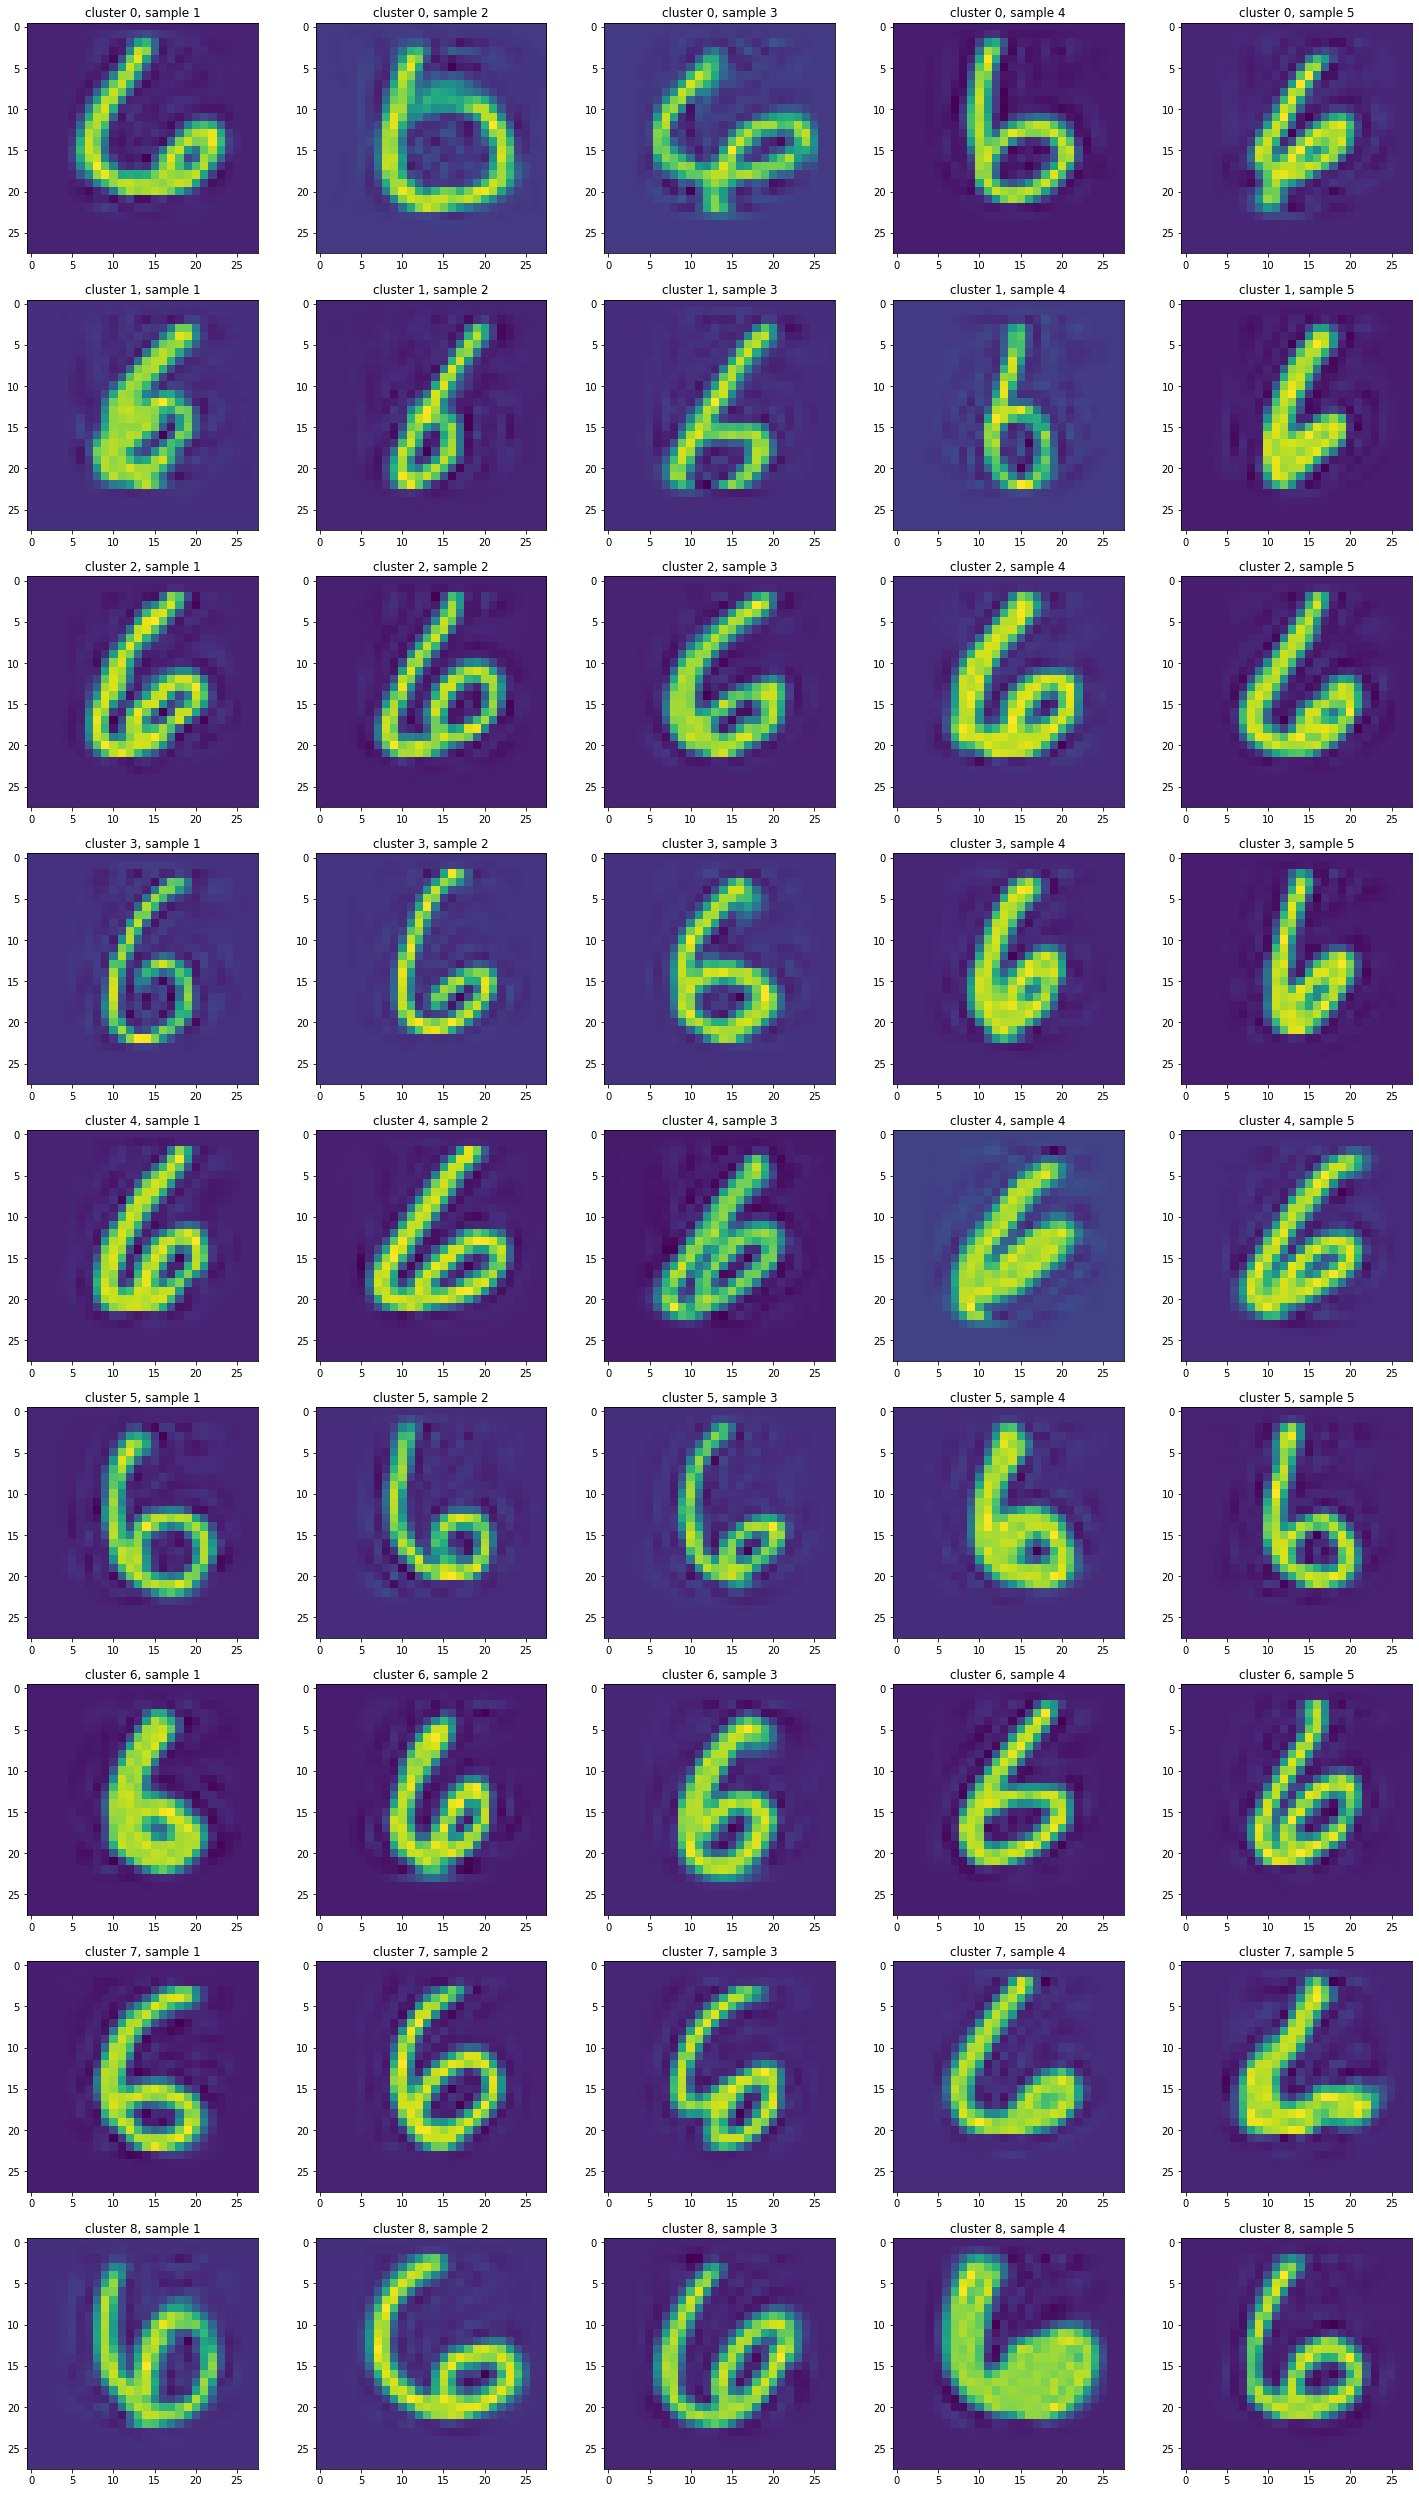

In [30]:
cluster_visualization(cate_images_transformed, hc_label)

## 1.3 Category = 9

In [31]:
category = 9
print(category)

9


In [32]:
cate_images = train_images[np.where(train_labels==category)[0]]
cate_labels = train_labels[np.where(train_labels==category)[0]]

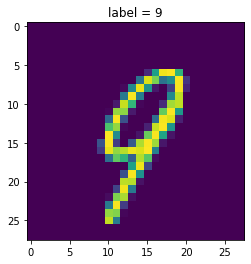

In [33]:
plt.figure()
plt.imshow(cate_images[2].reshape((28,28)))
plt.title("label = %d"%(cate_labels[2]))
plt.show()

### 1.3.1 PCA降维

In [34]:
pca = PCA()
pca.fit(cate_images)

PCA()

In [35]:
n_PCs = calculateNPCs(pca.explained_variance_ratio_, ratio=0.95)
print("选择占比超过95%%的n_Pc = %d"%(n_PCs))

选择占比超过95%的n_Pc = 110


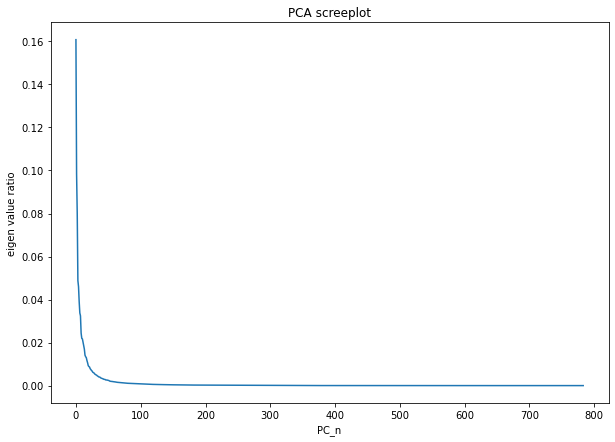

In [36]:
plt.figure(figsize=(10,7))
plt.plot(pca.explained_variance_ratio_, "-")
plt.xlabel("PC_n")
plt.ylabel("eigen value ratio")
plt.title("PCA screeplot")
plt.show()

In [37]:
pca = PCA(n_components = n_PCs)
cate_images_transformed = pca.fit_transform(cate_images)

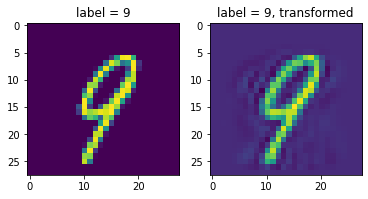

In [38]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cate_images[2].reshape((28,28)))
plt.title("label = %d"%(cate_labels[2]))
plt.subplot(1,2,2)
plt.imshow(pca.inverse_transform(cate_images_transformed[2]).reshape((28,28)))
plt.title("label = %d, transformed"%(cate_labels[2]))
plt.show()

### 1.3.2 Clustering

#### 1.3.2.1 KMeans

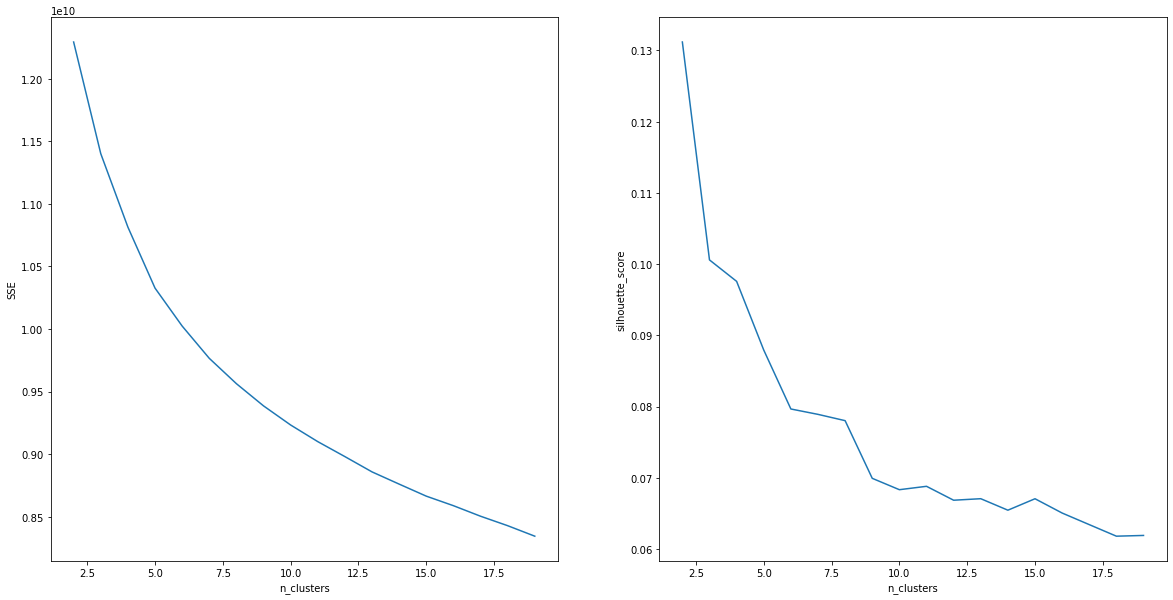

In [39]:
kmeans_plot(cate_images_transformed, cate_labels, title = None)

根据轮廓系数和SSE，选取n_clusters = 8

In [40]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(cate_images_transformed)
kmeans.labels_

array([3, 0, 0, ..., 5, 0, 0], dtype=int32)

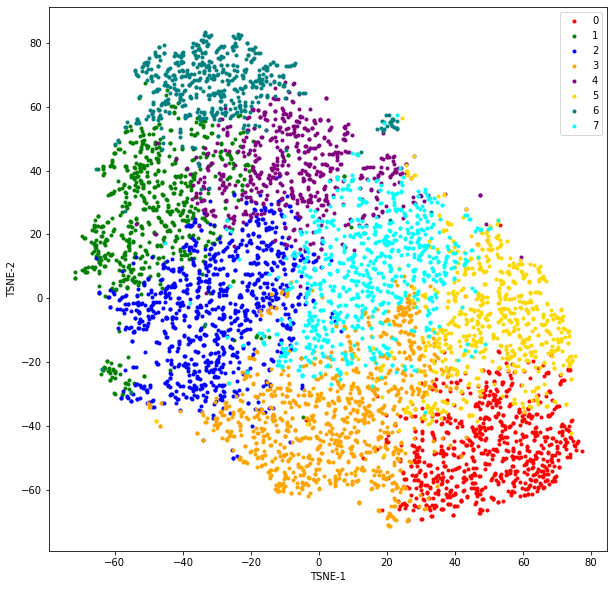

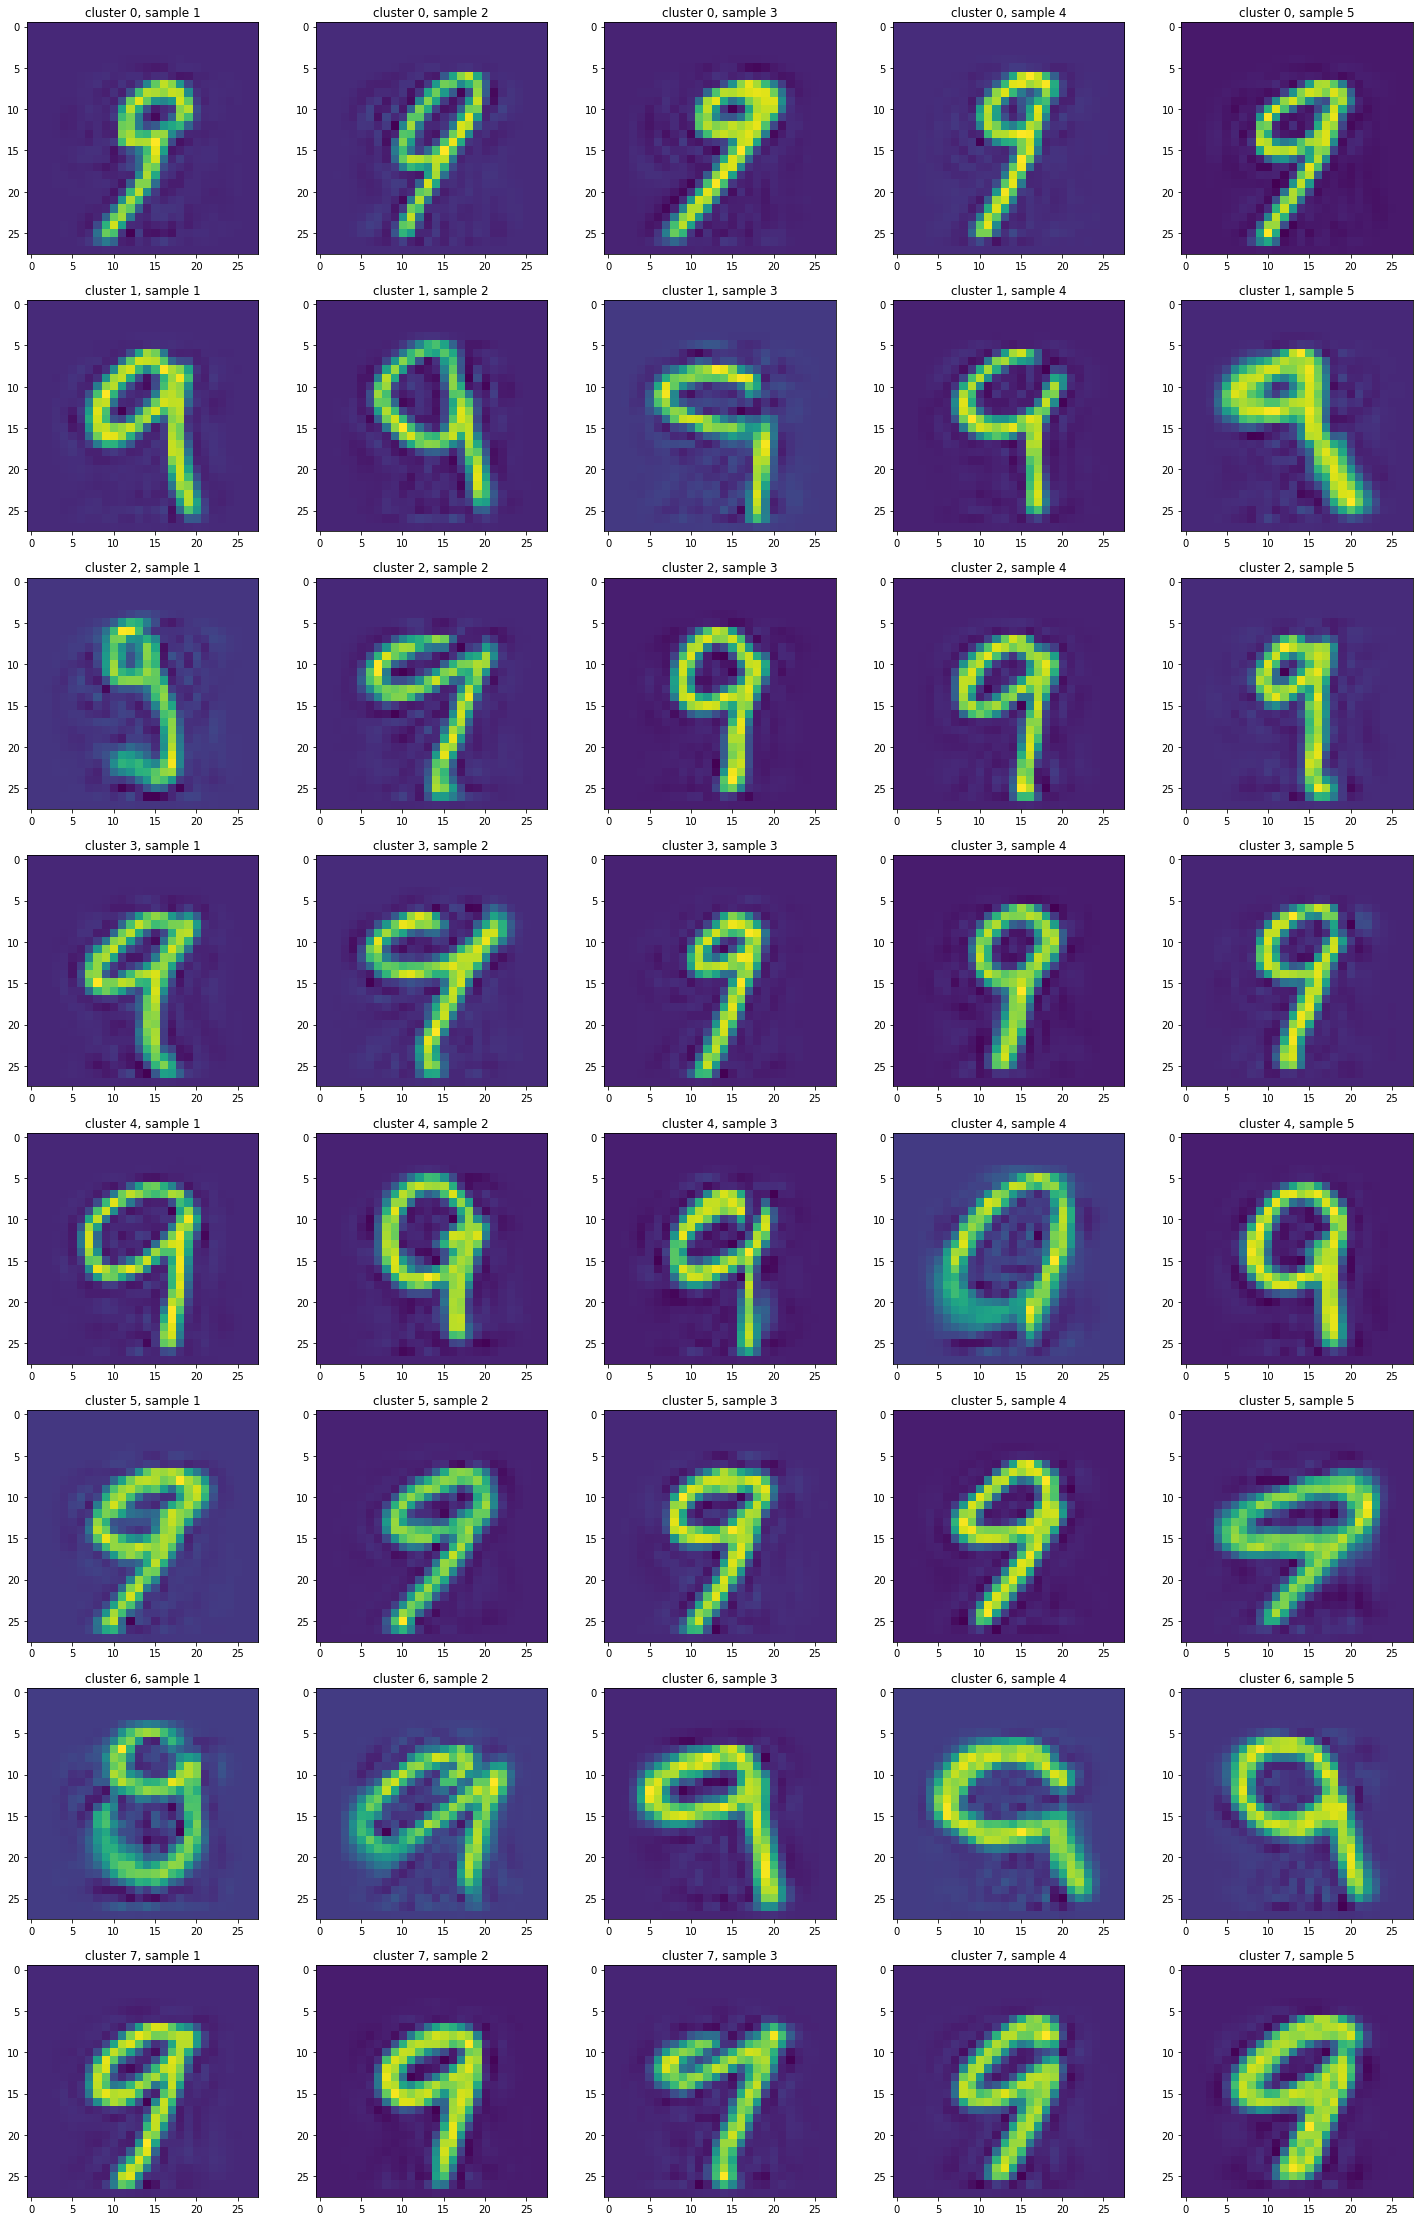

In [41]:
cluster_visualization(cate_images_transformed, kmeans.labels_)

#### 1.3.2.2 GMM

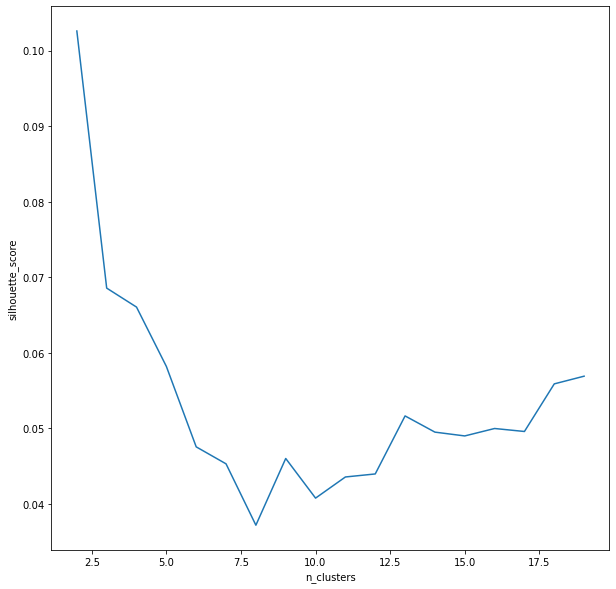

In [42]:
gmm_plot(cate_images_transformed, cate_labels)

In [43]:
gmm = GMM(n_components = 8, random_state=42)
gmm_label = gmm.fit_predict(cate_images_transformed)

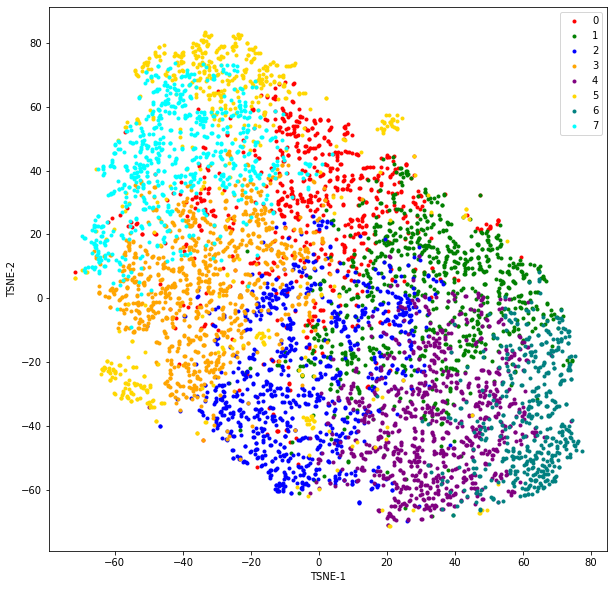

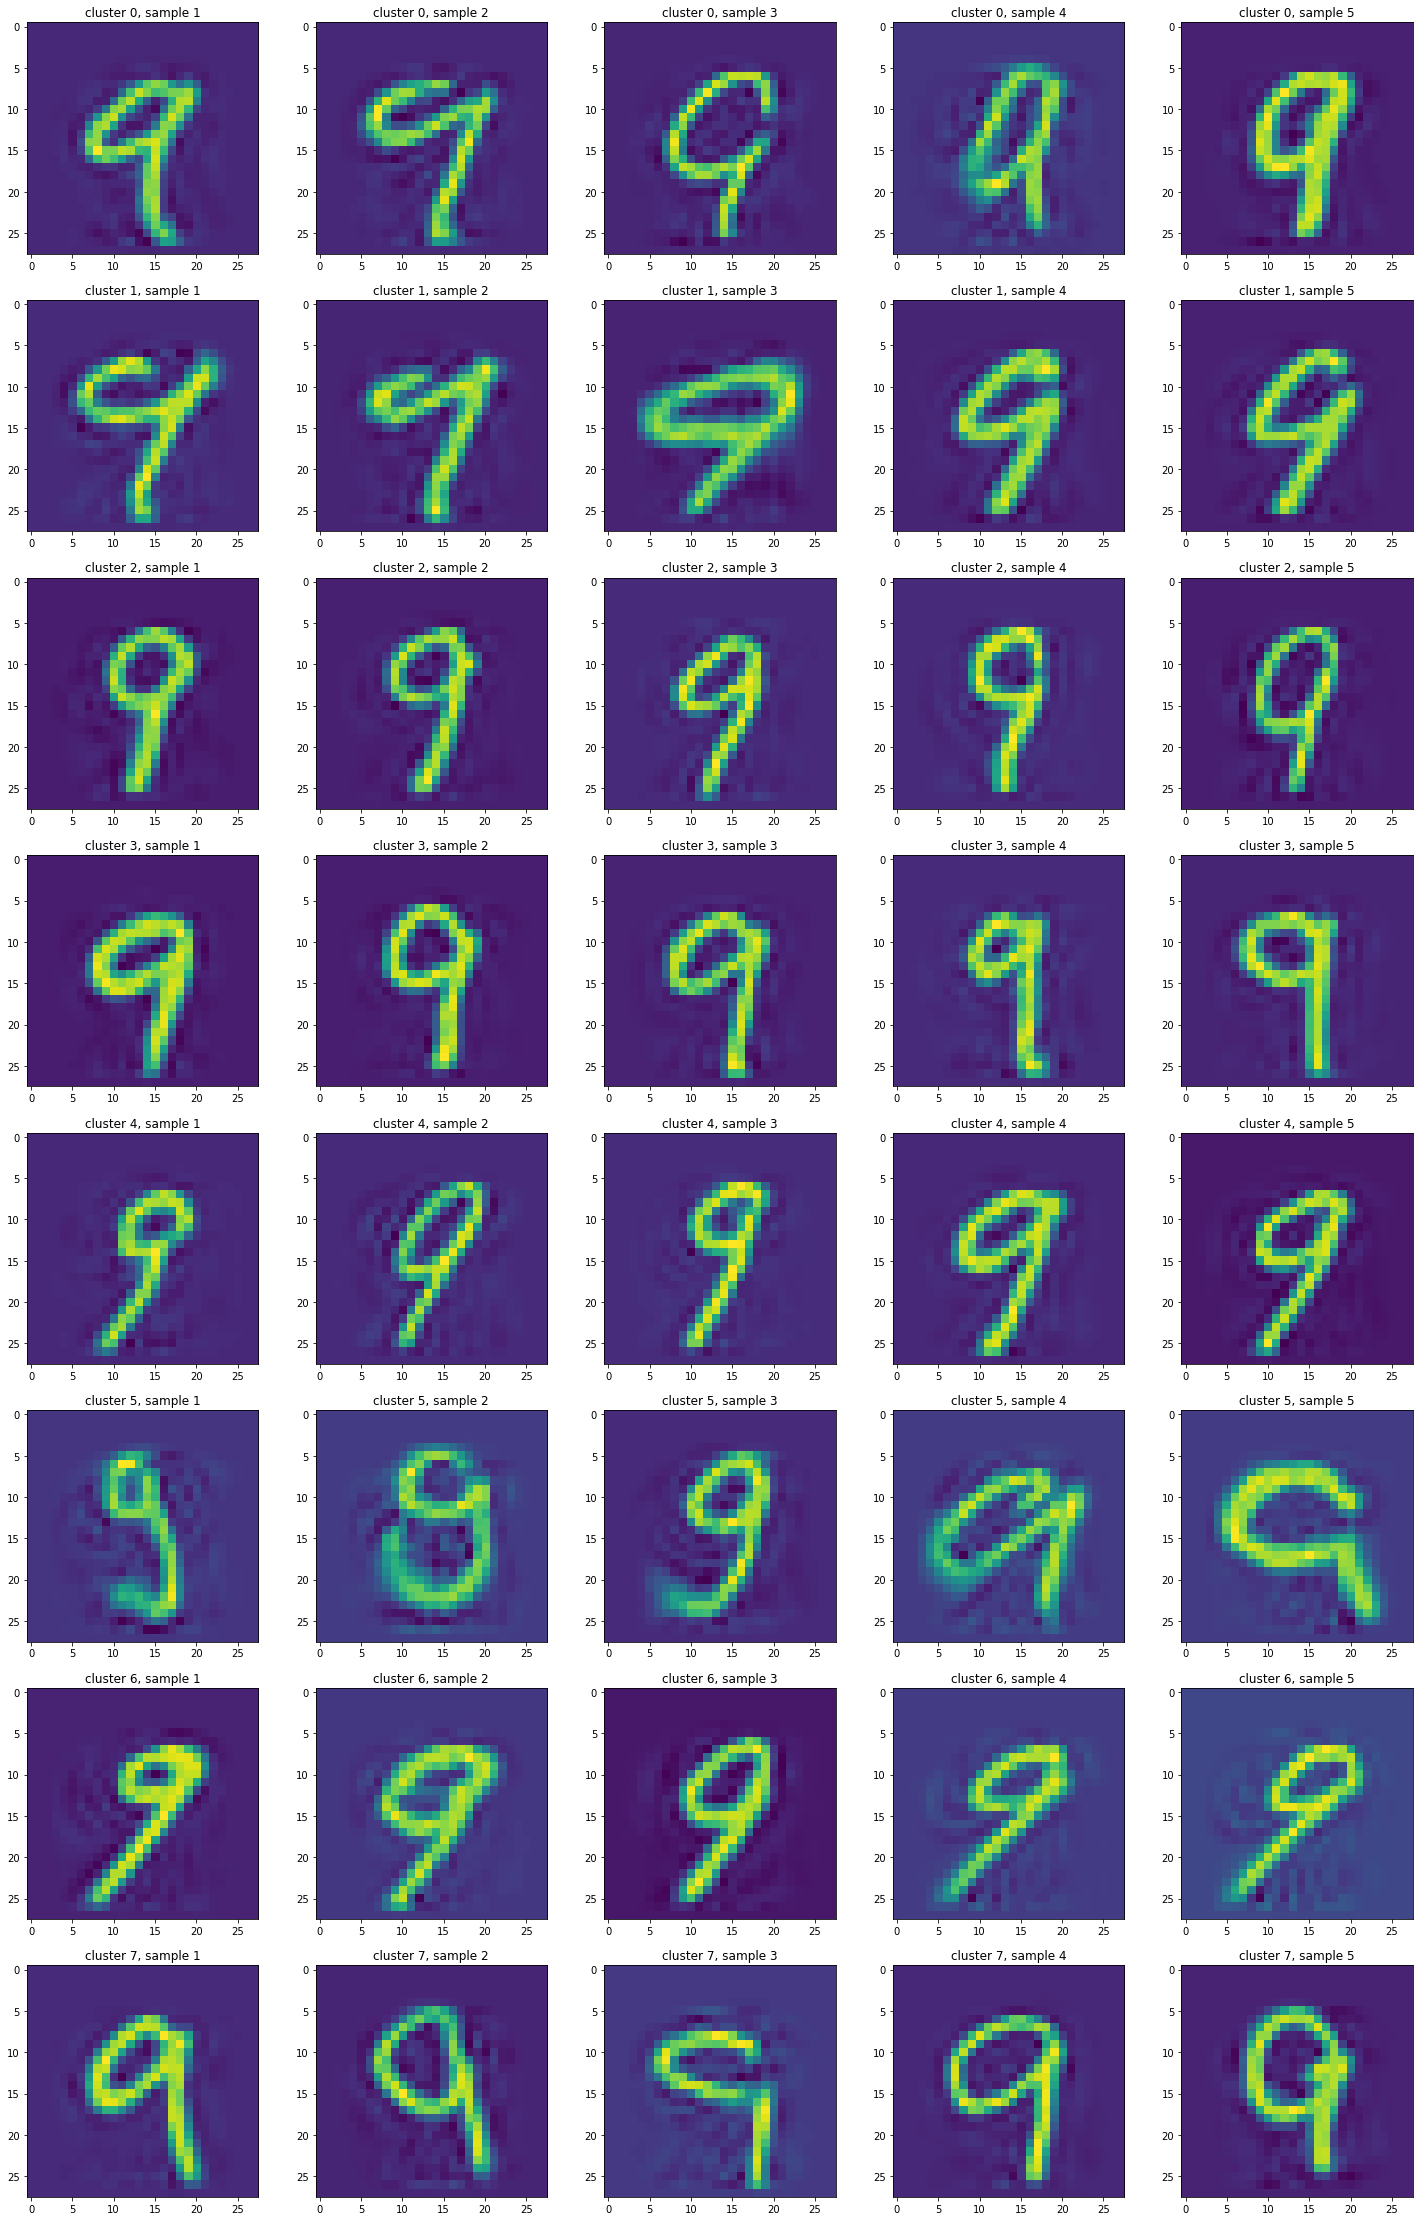

In [44]:
cluster_visualization(cate_images_transformed, gmm_label)

#### 1.3.2.3 Hierarchical clustering

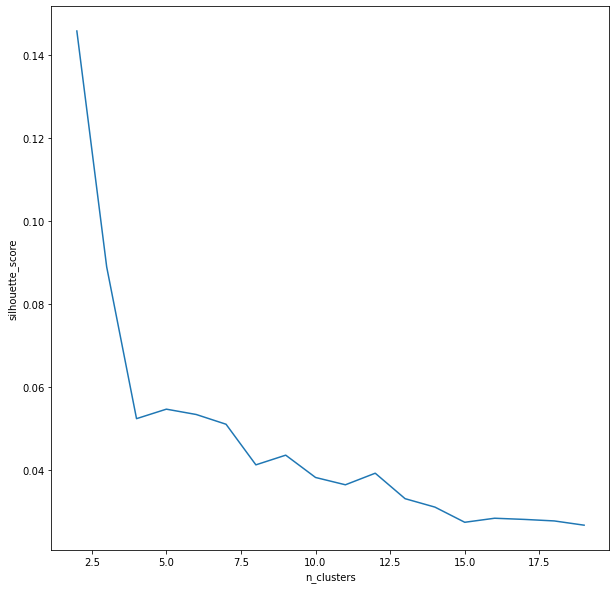

In [45]:
HC_plot(cate_images_transformed, cate_labels)

In [46]:
hc = HC(distance_threshold=0, n_clusters=None)
hc_label = hc.fit_predict(cate_images_transformed)

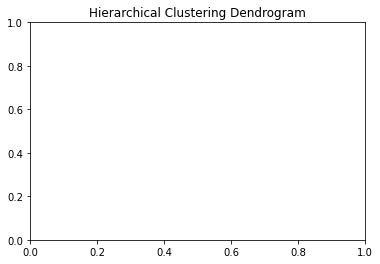

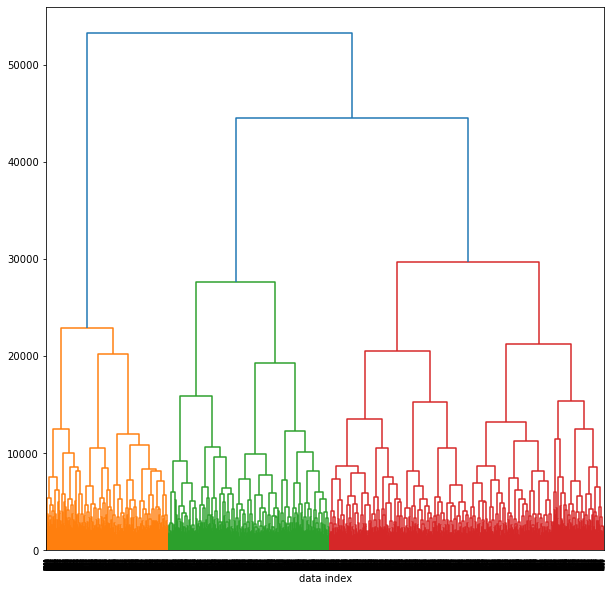

In [47]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plt.figure(figsize=(10,10))
plot_dendrogram(hc)
plt.xlabel("data index")
plt.show()

In [48]:
hc = HC(n_clusters=8)
hc_label = hc.fit_predict(cate_images_transformed)

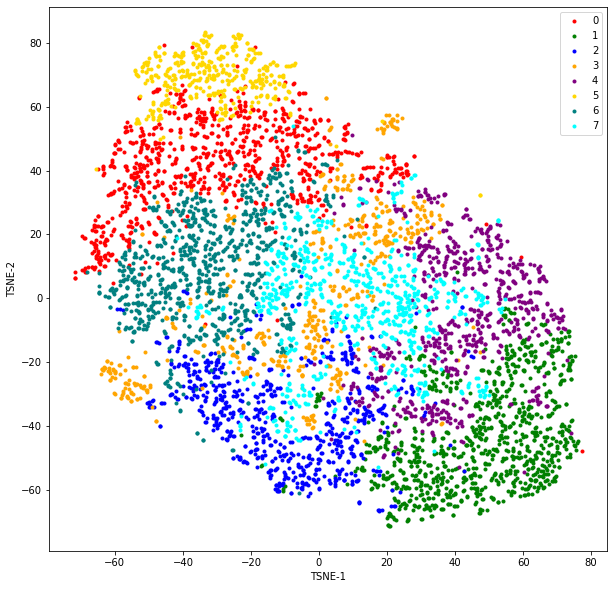

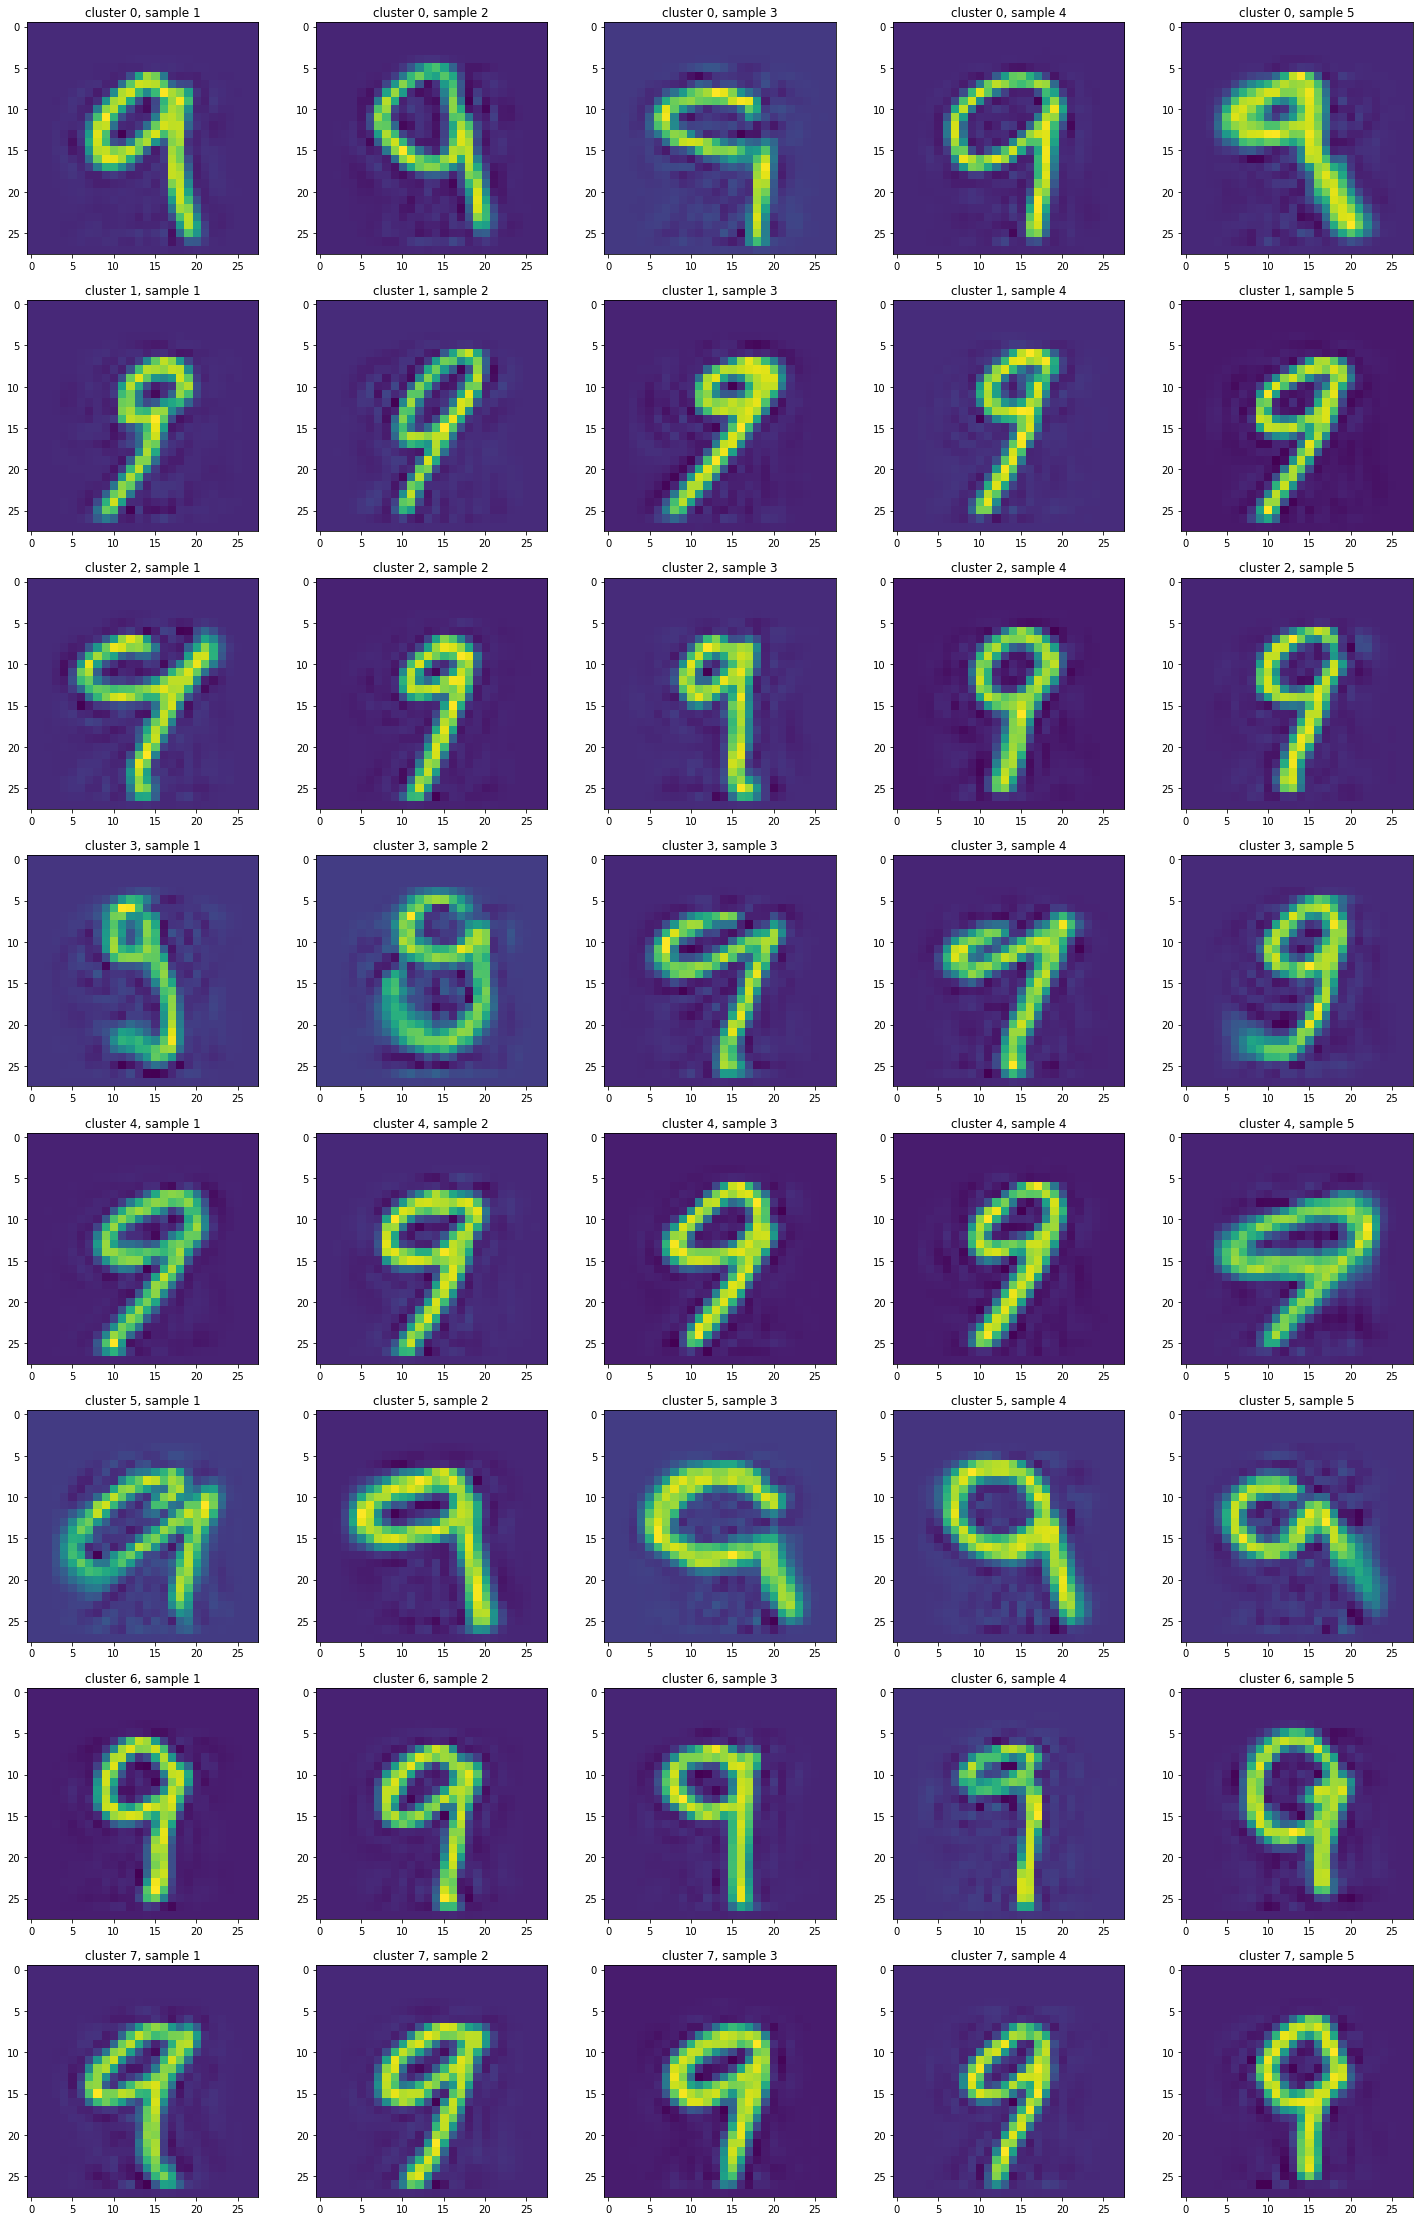

In [49]:
cluster_visualization(cate_images_transformed, hc_label)

## 1.4 PCA all

In [50]:
pca_all = PCA()
pca_all.fit(train_images)

PCA()

In [51]:
n_PCs_all = calculateNPCs(pca_all.explained_variance_ratio_, ratio=0.95)
print("选择占比超过95%%的n_Pc = %d"%(n_PCs_all))

选择占比超过95%的n_Pc = 153


In [52]:
pca_all = PCA(n_components = n_PCs_all)
train_images_transformed = pca_all.fit_transform(train_images)

In [54]:
tsne = TSNE(n_components=2, random_state=42)
dots = tsne.fit_transform(train_images_transformed)
tsne = TSNE(n_components=2, random_state=42)
udots = tsne.fit_transform(train_images)

In [56]:
kmeans1 = KMeans(n_clusters=10)
kmeans1.fit(train_images)
kmeans2 = KMeans(n_clusters=10)
kmeans2.fit(train_images_transformed)

KMeans(n_clusters=10)

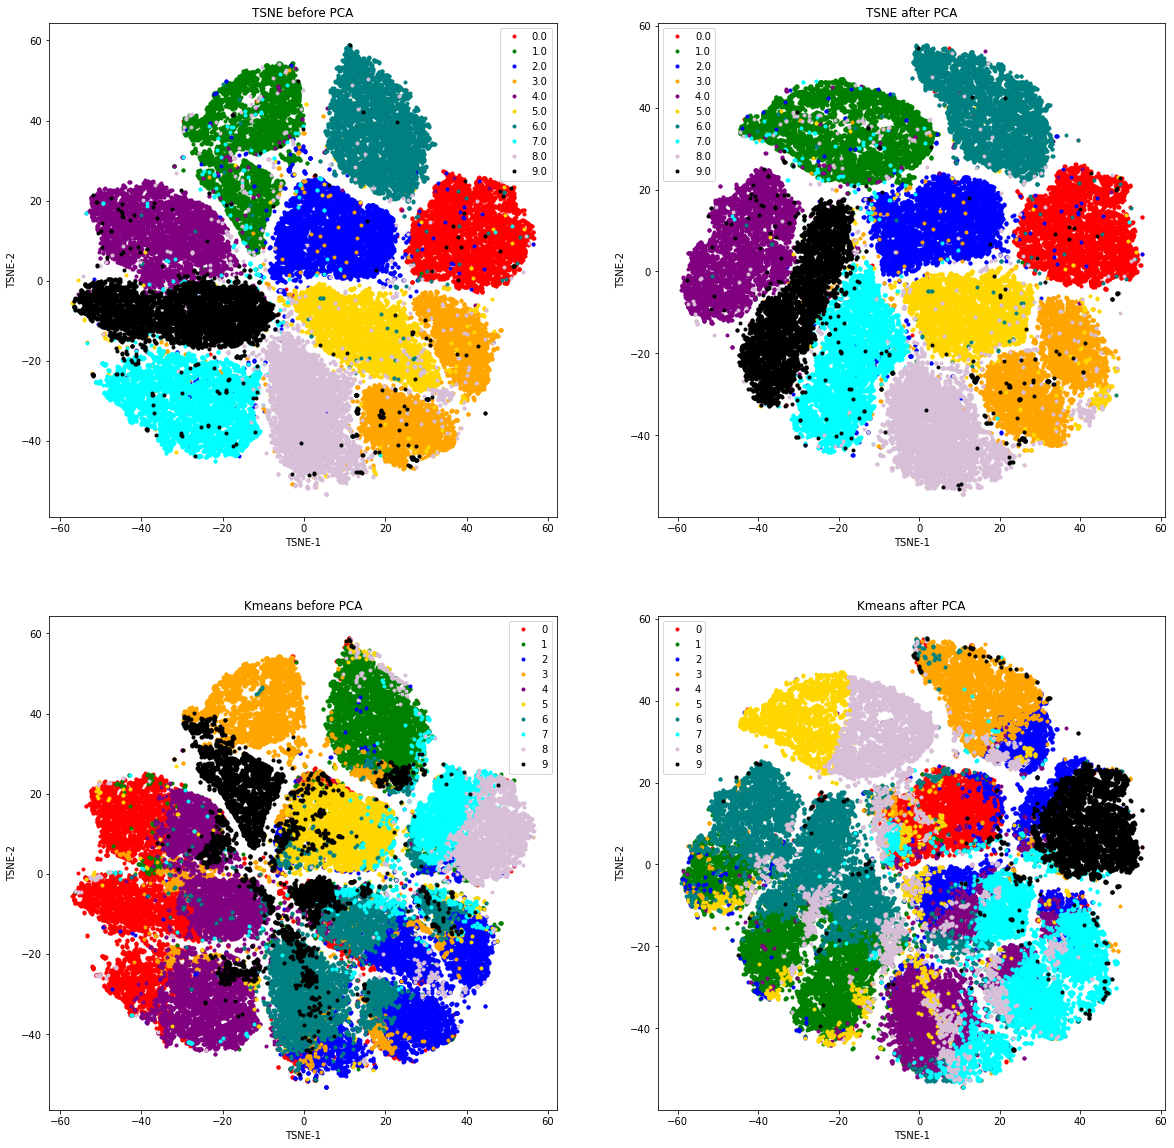

In [63]:
colors = ["red", "green", "blue", "orange", "purple", "gold", "teal", "cyan", "thistle", "black"]
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
labels = np.unique(train_labels)
for i, label in enumerate(labels):
    idx = np.where(train_labels==label)[0]
    plt.plot(udots[idx,0], udots[idx,1], ".", color=colors[i], label=label)
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("TSNE before PCA")
plt.legend()

plt.subplot(2,2,2)
labels = np.unique(train_labels)
for i, label in enumerate(labels):
    idx = np.where(train_labels==label)[0]
    plt.plot(dots[idx,0], dots[idx,1], ".", color=colors[i], label=label)
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("TSNE after PCA")
plt.legend()

plt.subplot(2,2,3)
labels = np.unique(kmeans1.labels_)
for i, label in enumerate(labels):
    idx = np.where(kmeans1.labels_==label)[0]
    plt.plot(udots[idx,0], udots[idx,1], ".", color=colors[i], label=label)
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("Kmeans before PCA")
plt.legend()

plt.subplot(2,2,4)
labels = np.unique(kmeans2.labels_)
for i, label in enumerate(labels):
    idx = np.where(kmeans2.labels_==label)[0]
    plt.plot(dots[idx,0], dots[idx,1], ".", color=colors[i], label=label)
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.title("Kmeans after PCA")
plt.legend()

plt.show()